Ce notebook peut être exécuté en ligne avec le binder :  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fchatelain/ExemplesFLO/master?urlpath=lab/tree/BE2_AlgoWidrow_template.ipynb)

In [1]:
# afficher des figures dans le notebook
# utiliser 'widget' au lieu de 'inline' pour un affichage interactif
%matplotlib inline

# BE 2 - Filtrage Linéaire Optimal 


**Objectif :** Estimer l'électrocardiogramme (ECG) d'un foetus chez une femme enceinte.

Ce notebook python suit la trame de l'énoncé du [BE sur Experience de Widrow](https://chamilo.grenoble-inp.fr/courses/ENSE3A24EMAABJ0/document/BE_2/BE_widrow.pdf?cidReq=ENSE3A24EMAABJ0&id_session=0&gidReq=0&gradebook=0&origin=) (à bien lire pour comprendre le problème et le travail demandé), et est volontairement déjà très complet. Le but est que vous vous concentriez sur l'essentiel : 
- le principe de l'algorithme de Widrow (Récursif)
- sa mise en oeuvre (sur des signaux réels) et le dimensionnement des paramètres du filtre
- l'interprétation des résultats

Des commentaires et des questions vous sont régulièrement adressés afin de vous guider, et les parties que vous devrez modifier dans le code sont toujours suivies de la mention `FIXME` en commentaire.

*Le bloc de code qui suit est un préambule contenant l'ensemble des fonctions utiles à ce BE*.

In [2]:
# Dépendances vers les fonctions utiles pour construire/appliquer le filtre de Wiener
import scipy.io # Lire les données en .mat
import numpy as np # Représentation machine par np array

# Dépendance pour les graphiques
import matplotlib.pyplot as plt

## I. L'expérience de Widrow

### 1. Principe

Les ECG abdominaux enregistrés sur une femme enceinte donnent accès aux rythmes cardiaques de la mère (ECG maternel) mais également du, ou des, fœtus (ECG fœtal). La difficulté majeure lors de l’estimation de l’ECG
fœtal réside dans le fait que son amplitude est de l’ordre de 2 à 1000 fois inférieure à celle de l’ECG
maternel (en raison des différents tissus/milieux à traverser, et tout simplement car le cœur est plus
petit).  Ceci est illustré sur la figure ci-dessous de signaux sur la bande 3-35Hz : (a) ECG maternel (électrode thoracique) et (b) ECG fœtal + maternel (électrode abdominale). *Source Widrow 1975*


![signaux ECG](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE2/signaux_ecg.svg?inline=false)


L’exploitation directe des enregistrements est donc difficile ; il s'avère nécessaire d’éliminer préalablement les interférences dues à l’ECG maternel. L'algorithme de Widrow (filtre LMS), qui s'adapte au caractère non-stationnaire des signaux (ici les variations des rythmes cardiaques, du médium de propagation,...), rend possible ce débruitage.


L’expérience est conduite de la manière suivante. La voie signal, ou voie primaire, est le signal
observé sur une électrode abdominale. Ce signal correspond à la superposition de l’ECG fœtal - le
signal utile - et de l’ECG maternel - le bruit que l’on cherche à éliminer. Afin de supprimer ce bruit,
il est nécessaire de disposer d’une référence *bruit seul* : des électrodes sont placées sur le thorax de
la femme enceinte afin de ne mesurer que l'ECG maternel, comme cela est illustré sur le schéma ci-dessous

![schéma des électrode](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE2/schema_electrodes.png?inline=false)

Cette référence est filtrée de manière adaptative et soustraite du signalobservé sur l’électrode abdominale afin d’obtenir une estimée du signal utile, l’ECG fœtal. Ceci conduit au filtre adaptatif annulateur de bruit schématisé sur la figure ci-dessous 

![schéma du filtre LMS pour débruiter l'ECG foetal](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE2/adapt_noise_canceller.svg?inline=false)

où la flèche qui traverse le filtre rappelle que les coefficients sont mis à jour, de manière adaptative, en fonction de l'erreur de prédiction.

### 2. Chargement des signaux ECG

Le fichier `foetal_ecg.mat`  regroupe les signaux ECG enregistrés sur une femme enceinte (8 électrodes). La fréquence d’échantillonnage est $F_e = 250$Hz, et la durée d'acquisition est de $10$ secondes (ce qui correspond à $N = 2500$ échantillons).

Ce fichier est chargé sous la forme du tableau ``foetal_ecg`` de taille $8 \times 2500$ dont chaque ligne correspond au signal enregistré sur l'une des 8 électrodes:
<ul>
    <li> Electrodes 1-5: abdomen, ECG de la mère + foetus -> <b>Voie signal</b>.
    <li> Electrodes 6-8: Thorax, seul le rythme cardiaque de la mère est mesuré -> Référence <b>bruit seul</b>.
</ul>

In [3]:
Fe = 250; # Fréquence d'échantillonnage en Hz

# Récupération des données ecg
#    Rq: les signaux sont déjà centrés
file = scipy.io.loadmat('foetal_ecg.mat')
foetal_ecg = np.array(file['foetal_ecg'])

# Nombre d'échantillons
N = foetal_ecg.shape[1]

Affichage des voies dans le domaine temporel.

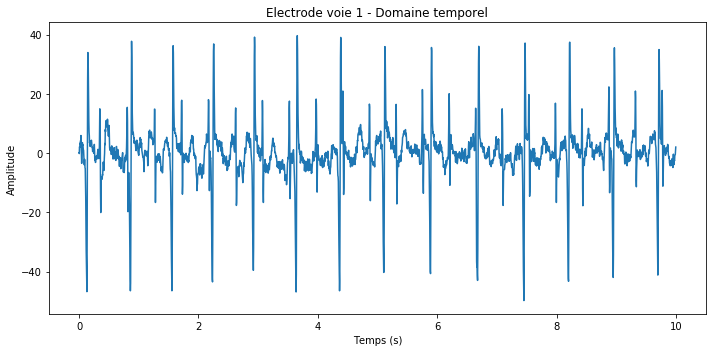

In [4]:
# Choix de la voie à afficher (entre 1 et 8)
voie = 1 # 1-5 : abdomen, 6-8 : thorax

# Affichage dans le domaine temporel
temps = np.arange(N)/Fe

plt.figure(figsize = (10, 5))
plt.title("Electrode voie {} - Domaine temporel".format(voie))
#attention à l'indexation des tableaux : 0 est le premier élément
plt.plot(temps, foetal_ecg[voie - 1, :]) 
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()

Afficher et visualiser les différentes électrodes (voies 1 à 8),

**Questions** 

- Quelle différence peut-on bien constater entre les électrodes abdominales et thoraciques  ?
- Le rapport signal (ecg foetal) à bruit (ecg maternel) est il similaire parmi les électrodes abdominales ?


## II. Algorithme de Widrow (LMS)

On cherche dans un premier temps à débruiter le signal de la première électrode abdominale (voie 1) à partir de la référence *bruit seul* donnée par la  première électrode thoracique (voie 6)


### Entrées de l'algorithme adaptatif de Widrow

In [5]:
# Signal à débruiter
elec_abdo = 1
abdomen_ecg = foetal_ecg[elec_abdo - 1, :] # Vecteur ligne 1 x N

# Référence bruit seul: Voie secondaire
ireference = 6
thorax_ecg = foetal_ecg[ireference - 1, :] # Vecteur ligne 1 x N

### Filtrage adaptatif LMS

On rappelle que l'algorithme LMS s'écrit en pseudo-code comme

`Ìnput`: signal $x$, référence *bruit seul* $y$

`Parameters`: 
  - $L$ la longueur du filtre LMS
  - $\mu>0$ le pas d'adaptativité
  
`Ìnitialization` : réponse du filtre $\mathbf{w}_0$ fixée, pex $\mathbf{w}_0 = \boldsymbol{0}$

`For i= 1 to N`:
  * `Form` the length $L$ vector $\mathbf{y}_k = (y[k], \ldots , y[k − L + 1])^T$,
  * `Compute` $e_k$ ← $x[k] - \mathbf{w}_{k-1}^T \mathbf{y}_k$ [Erreur de prédiction]
  * `Compute` $\mathbf{w}_k$ ← $\mathbf{w}_{k-1} +\mu e_k \mathbf{y}_k$ [Maj du filtre]
  * `Compute` $\hat{\nu}[k]$ ← $\mathbf{w}_k^T  \mathbf{y}_k$ [Calcul de l'estimée à la date k]

`return` $\hat{\nu}$ [estimée du bruit à supprimer, ici l’ECG maternel]



#### 1. Initialisation et choix des paramètres du filtre.

Les deux paramètres clés du filtre LMS sont 
- la longueur $L$ du filtre RIF, 
- le pas d'adaptativité $\mu$

On peut dans un premier temps fixer $L$ à une valeur arbitraire (qui pourra être optimisée par la suite)

Afin de choisir une valeur de $\mu$ appropriée, on peut calculer une borne *théorique*  $B_\mu$ au delà de laquelle le filtre explose (en tout cas la convergence en moyenne n'est plus garantie).
Un calcul simple expliqué dans [l'énoncé](https://chamilo.grenoble-inp.fr/courses/ENSE3A24EMAABJ0/document/BE_2/BE_widrow.pdf?cidReq=ENSE3A24EMAABJ0&id_session=0&gidReq=0&gradebook=0&origin=) 
donne une borne *théorique*
$$
B_\mu = \frac{2}{L\Gamma_y[0]}
$$

In [6]:
L = 8   # Ordre du filtre RIF associé au signal de référence
# Borne sup du pas d'adaptivité afin de garantir la convergence (CS)
borne_mu = 2 / ( L * np.mean(np.power(thorax_ecg, 2)) )

# Attention : les hypothèses d'où decoulent les conditions suffisantes 
# qui assurent la cvgce ne sont pas forcément verifiées...
# Afin d'avoir l'adaptivité necessaire et la convergence, on prend une 
# valeur inferieure pour le pas d'adaptivité de l'algo LMS
mu = borne_mu / 1000

# Pré-allocation de mémoire - Initialisation
ecg_maternel_estim = np.zeros((N)) # Estimation du cardio maternel
erreur = np.zeros((N)) # Innovation / Erreur de prédiction
w = np.zeros((L, N)) # Réponse du filtre à chaque instant k=0...N-1


Remarque: la valeur du filtre initial de référence w0 = w[:, 0] = 0
=> Valeur initiale du signal prédit = 0

#### 2. Implémentation de l'algorithme 1 (Filtrage adaptatif de Widrow) tel qu'il est décrit sur l'énoncé.

In [7]:
# Initialisation
erreur[0] = abdomen_ecg[0]
w[0, 0] = mu * erreur[0] * thorax_ecg[0]
ecg_maternel_estim[0] = w[0, 0] * thorax_ecg[0]


# Iterations
for k in range(1, N):
    # Mise en forme du signal pour l'opération de filtrage (convolution)
    if k < L:
        # Tant que le nombre déchantillons disponibles est plus 
        # petit que le filtre, le signal est complété par des 0
        y_k = np.concatenate((thorax_ecg[k::-1],
                              np.zeros((L - k - 1))
                             ))
    else:
        y_k = thorax_ecg[k:(k-L):-1]
    
    # Erreur de prédiction
    erreur[k] = abdomen_ecg[k] #FIXME 
    # M-à-j du filtre
    w[:, k] = 0 #FIXME 
    # Contribution maternelle à la date k
    ecg_maternel_estim[k] = 0 #FIXME 

#### 3. Visualisation et interprétation des résultats.

In [ ]:
# Affichage dans le domaine temporel
temps = np.arange(N)/Fe

plt.figure(figsize = (10, 10))
# thorax_ecg
plt.subplot(3, 1, 1)
plt.grid()
plt.title("Référence - Electrode thorax")
plt.plot(temps, thorax_ecg)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
# ECG Maternel estimé
plt.subplot(3, 1, 2)
plt.grid()
plt.title("Signal : Electrode abdomen {}".format(elec_abdo))
plt.plot(temps, abdomen_ecg, '-b', label="Observation")
plt.plot(temps, ecg_maternel_estim, '-k', label="ECG Mat. Estim")
plt.legend()
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
# ECG Foetus estimé
plt.subplot(3, 1, 3)
plt.grid()
plt.title("ECG Foetus estimé")
plt.plot(temps, abdomen_ecg - ecg_maternel_estim, '-r')
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()

Jouer sur le paramètre  $\mu$  et visualiser/interpréter les résultats

**Questions**
- Que se passe t'il lorsque $\mu$ est trop petit ou trop grand, et est-ce cohérent avec la théorie ?
- Qelle valeur de $\mu$ vous semble ici appropriée afin d'estimer *au mieux* les ECG maternel et foetal (on utilisera cette valeur dans la suite) ?

#### 4. Courbes d'apprentissage

In [ ]:
plt.figure(figsize = (10, 8))
# thorax_ecg
plt.subplot(2, 1, 1)
plt.grid()
plt.title("Courbe d'apprentissage - Module de l'erreur de prédiction")
plt.plot(temps, abs(erreur))
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
# ECG Maternel estimé
plt.subplot(2, 1, 2)
plt.grid()
plt.title("Premier coefficient du filtre associé à la référence")
plt.plot(temps, w[0, :])
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()

Visualiser/interpréter les deux courbes ci-dessus qui montrent *l'apprentissage* dul filtre LMS au cours des itérations:

**Questions**
- à quoi correspondent les pics de l'erreur de prédiction ?
- pourquoi l'évolution du premier coefficient du filtre est elle (à peu près) constante par morceaux ?

#### 5. Choix de la longueur du filtre 

Ré-itérer les traitements précédents en jouant sur la longueur $L$ du filtre LMS et visualiser/interpréter les résultats

**Questions**

- Que se passe t'il lorsque $L$ est *trop grand* ? Comment l'interpréter ?
- Que se passe t'il lorsque $L$ est *trop petit* ? Comment l'interpréter ?
- Quelle valeur de $L$ vous semble ici appropriée ?

#### 6. Débruitage des autres électrodes abdominales 

Ré-itérer les traitements précédents avec les autres électrodes abdominales.

**Questions**
- les résultats sont ils toujours aussi satisfaisants que ceux obtenus pour la première électrode ?

## III. Algorithme de Widrow multi-références

Il s'agit ici de reprendre le code précédent en prenant en compte la totalité des références disponibles (6 à 8).
L'étape la plus importante concerne la réécriture de l'algorithme telle que la réponse du filtre prenne en compte ces 3 références.

Une façon simple de procéder consiste à condidérer que le filtre LMS global est obtenu comme la somme des trois sous filtres qui prennent chacun en entrée une des électrodes de référence. Le principe est schématisé sur la figure ci dessous :

![schéma du filtre multi références](https://gricad-gitlab.univ-grenoble-alpes.fr/ds-courses/materials-optimal-filtering/-/raw/master/figs/BE2/schema_multi_ref.svg?inline=false)

**Question**
-  quel peut être l'intérêt du filtre multi-références par rapport au filtre précédent ?

In [10]:
# Signal à débruiter
elec_abdo = 1
abdomen_ecg = foetal_ecg[elec_abdo - 1, :] # Vecteur ligne 1 x N

# Référence bruit seul: Voie secondaire
nRef = 3
ireferences = np.arange(6,6 + nRef)
thorax_ecg_mult = foetal_ecg[ireferences - 1, :] # Vecteur ligne nRef x N

In [11]:
# Ordre du filtre RIF associé au signal de référence
L = 8 # FIXME: choisir la valeur appropriée

# Borne sup du pas d'adaptivité afin de garantir la convergence (CS)
borne_mu = 2 / ( L * np.mean(np.power(thorax_ecg_mult[:, :], 2)) )

# pas d'adaptativité du filtre multiréférences
mu = borne_mu / 1000 # FIXME: choisir la valeur appropriée

# Pré-allocation de mémoire - Initialisation
ecg_maternel_estim_mult = np.zeros((N)) # Estimation du cardio maternel
erreur_mult = np.zeros((N)) # Innovation / Erreur de prédiction

# il y a maintenant une réponse par électrode de référence
# le filtre LMS étant la somme de chacun de ces `nRef` filtres
w_mult = np.zeros((L, nRef, N))  # Réponses des (sous)filtres pour chaque instant


In [12]:
# Initialisation
erreur_mult[0] = abdomen_ecg[0]
w_mult[0, :, 0] = mu * erreur_mult[0] * thorax_ecg_mult[:, 0].T
ecg_maternel_estim_mult[0] = np.dot(w_mult[0, :, 0], thorax_ecg_mult[:, 0])
# Iterations
for k in range(1, N):
    # Mise en forme pour l'opération de convolution
    if k < L:
        y_k = np.concatenate((thorax_ecg_mult[:, k::-1],
                              np.zeros((nRef, L - k - 1))),
                              axis = 1)
    else:
        y_k = thorax_ecg_mult[:, k:(k-L):-1]
    
    # Erreur de prédiction
    erreur_mult[k] = abdomen_ecg[k] # FIXME
    # M-à-j du filtre
    w_mult[:, :, k] = 0 # FIXME
    # Contribution maternelle à la date k
    ecg_maternel_estim_mult[k] = 0 # FIXME

Reprendre ici les traitements effectués dans la partie précédente afin d'implémenter le filtre multi-références (en choisissant des valeurs appropriées pour $L$ et $\mu$) et interprétez les résultats obtenus.

**Question**
- Les résultats obtenus sont-ils meilleurs que ceux obtenus dans le cas mono-référence ?
- Les signaux abdominaux sont-ils correctement débruités ? Si ce n'est pas le cas, que pensez vous du signal associé à l'électrode abdominale concernée ? 